# Setting up Mindcontrol to QC Freesurfer Outputs

This tutorial will set up a Mindcontrol instance for Freesurfer output QC. The first step is to clone the Mindcontrol repository from GitHub and checkout the FreeSurfer branch:

```bash
git clone https://github.com/akeshavan/mindcontrol
cd mindcontrol
git checkout origin/FreeSurfer
```

Then start Mindcontroln typing `meteor`:

```bash
meteor
```

Navigate to http://localhost:3000, you should see an empty Mindcontrol UI:

![](images/freesurfer_empty_instance.png)

## Import FreeSurfer Subjects Directory Into Mindcontrol
This work flow reads the SUBJECTS_DIR variable, converts all volumetric data from .mgz into .nii.

### Import necessary packages

In [1]:
import os
import os.path as op
import nibabel as nb
from glob import glob
from IPython.display import Image
from nipype import MapNode, Workflow, Node
from nipype.interfaces.freesurfer import MRIConvert
from nipype.interfaces.io import DataSink
from nipype.interfaces.utility import IdentityInterface, Function
from IPython.display import Image

### Set your directories

In [2]:
# Set SUBJECTS_DIR, from Freesurfer
subjects_dir = os.path.abspath("../data/ds000114/derivatives/freesurfer/")
# Set the directory to save converted Freesurfer outputs (ideally, the mindcontrol base dir)
mindcontrol_base_dir = os.path.abspath("./mindcontrol_base_dir")
mindcontrol_outdir = os.path.abspath("./mindcontrol_base_dir/freesurfer")
# Set the directory where the nipype workflow saves intermediary files
workflow_working_dir = os.path.abspath("./scratch")

### Find all subjects in the Freesurfer directory

In [21]:
# Select subjects to prepare (this will do all inside the SUBJECTS_DIR)
subject_paths = glob(op.join(subjects_dir, "*"))

# SUBJECTS_DIR sometimes contains directories that aren't subjects, don't grab them

subjects = []
for path in subject_paths:
    subject = path.split('/')[-1]
    # check if mri dir exists, and don't add fsaverage
    if op.exists(op.join(path, 'mri')) and subject != 'fsaverage':
        subjects.append(subject)


# Volumes that will be prepared
volumes = ["brainmask.mgz", "wm.mgz", "aparc+aseg.mgz", "T1.mgz"]

### Helper functions

In [22]:
def data_grabber(subjects_dir, subject, volumes):
    import os
    volumes_list = [os.path.join(subjects_dir, subject, 'mri', volume) for volume in volumes]
    return volumes_list

In [23]:
def parse_stats(subjects_dir, subject):
    from os.path import join, exists
    
    aseg_file = join(subjects_dir, subject, "stats", "aseg.stats")
    lh_aparc = join(subjects_dir, subject, "stats", "lh.aparc.stats")
    rh_aparc = join(subjects_dir, subject, "stats", "rh.aparc.stats")
    
    assert exists(aseg_file), "aseg file does not exists for %s" %subject
    assert exists(lh_aparc), "lh aparc file does not exists for %s" %subject
    assert exists(rh_aparc), "rh aparc file does not exists for %s" %subject
    
    def convert_stats_to_json(aseg_file, lh_aparc, rh_aparc):
        import pandas as pd
        import numpy as np

        def extract_other_vals_from_aseg(f):
            line_numbers = [18,23,21,33,22]
            output = pd.DataFrame()
            with open(f,"r") as q:
                out = q.readlines()
                for line in line_numbers:
                    sname= out[line].split(",")[1][1:]
                    vol = out[line].split(",")[-2]
                    output = output.append(pd.Series({"StructName":sname,"Volume_mm3":vol}),ignore_index=True)
            return output

        df = pd.DataFrame(np.genfromtxt(aseg_file,dtype=str),columns=["Index",
                                                            "SegId",
                                                            "NVoxels",
                                                            "Volume_mm3",
                                                            "StructName",
                                                            "normMean",
                                                            "normStdDev",
                                                            "normMin",
                                                            "normMax",
                                                            "normRange"])

        df = df.append(extract_other_vals_from_aseg(aseg_file), ignore_index=True)
        
        aparc_columns = ["StructName", "NumVert", "SurfArea", "GrayVol",
                         "ThickAvg", "ThickStd", "MeanCurv", "GausCurv",
                         "FoldInd", "CurvInd"]
        tmp_lh = pd.DataFrame(np.genfromtxt(lh_aparc,dtype=str),columns=aparc_columns)
        tmp_lh["StructName"] = "lh_"+tmp_lh["StructName"]
        tmp_rh = pd.DataFrame(np.genfromtxt(rh_aparc,dtype=str),columns=aparc_columns)
        tmp_rh["StructName"] = "rh_"+tmp_rh["StructName"]

        aseg_melt = pd.melt(df[["StructName","Volume_mm3"]], id_vars=["StructName"])
        aseg_melt.rename(columns={"StructName": "name"},inplace=True)
        aseg_melt["value"] = aseg_melt["value"].astype(float)
        
        lh_aparc_melt = pd.melt(tmp_lh,id_vars=["StructName"])
        lh_aparc_melt["value"] = lh_aparc_melt["value"].astype(float)
        lh_aparc_melt["name"] = lh_aparc_melt["StructName"]+ "_"+lh_aparc_melt["variable"]
        
        rh_aparc_melt = pd.melt(tmp_rh, id_vars=["StructName"])
        rh_aparc_melt["value"] = rh_aparc_melt["value"].astype(float)
        rh_aparc_melt["name"] = rh_aparc_melt["StructName"]+ "_"+rh_aparc_melt["variable"]
        
        output = aseg_melt[["name",
                            "value"]].append(lh_aparc_melt[["name",
                                                            "value"]],
                                             ignore_index=True).append(rh_aparc_melt[["name",
                                                                                      "value"]],
                                                                       ignore_index=True)
        outdict = output.to_dict(orient="records")
        final_dict = {}
        for pair in outdict:
            final_dict[pair["name"]] = pair["value"]
        return final_dict
    
    output_dict = convert_stats_to_json(aseg_file, lh_aparc, rh_aparc)
    return output_dict
    

In [24]:
def create_mindcontrol_entries(mindcontrol_base_dir, output_dir, subject, stats):
    import os
    from nipype.utils.filemanip import save_json
    
    metric_split = {"brainmask": ["eTIV", "CortexVol", "TotalGrayVol"],
                    "wm": ["CorticalWhiteMatterVol","WM-hypointensities", 
                           "Right-WM-hypointensities","Left-WM-hypointensities"],
                    "aparcaseg":[]}
    
    volumes = ["brainmask.nii.gz", "wm.nii.gz", "aparc+aseg.nii.gz", "T1.nii.gz"]
    volumes_list = [os.path.join(output_dir, subject, volume) for volume in volumes]

    all_entries = []
    
    for idx, entry_type in enumerate(["brainmask", "wm", "aparcaseg"]):
        entry = {"entry_type":entry_type, 
                 "subject_id": subject, 
                 "name": subject}
        base_img = os.path.relpath(volumes_list[-1], mindcontrol_base_dir)
        overlay_img = os.path.relpath(volumes_list[idx], mindcontrol_base_dir)
        entry["check_masks"] = [base_img, overlay_img]
        entry["metrics"] = {}
        for metric_name in metric_split[entry_type]:
            entry["metrics"][metric_name] = stats.pop(metric_name)
        if not len(metric_split[entry_type]):
            entry["metrics"] = stats
        all_entries.append(entry)
    
    output_json = os.path.abspath("mindcontrol_entries.json")
    save_json(output_json, all_entries)
    return output_json

### Nodes

In [25]:
input_node = Node(IdentityInterface(fields=['subject_id',"subjects_dir",
                                            "mindcontrol_base_dir", "output_dir"]), name='inputnode')
input_node.iterables=("subject_id", subjects)
input_node.inputs.subjects_dir = subjects_dir
input_node.inputs.mindcontrol_base_dir = mindcontrol_base_dir
input_node.inputs.output_dir = mindcontrol_outdir

dg_node=Node(Function(input_names=["subjects_dir", "subject", "volumes"],
                      output_names=["volume_paths"], 
                      function=data_grabber), 
             name="datagrab")
#dg_node.inputs.subjects_dir = subjects_dir
dg_node.inputs.volumes = volumes


mriconvert_node = MapNode(MRIConvert(out_type="niigz"), 
                          iterfield=["in_file"], 
                          name='convert')

get_stats_node = Node(Function(input_names=["subjects_dir", "subject"],
                               output_names = ["output_dict"],
                               function=parse_stats), name="get_freesurfer_stats")

write_mindcontrol_entries = Node(Function(input_names = ["mindcontrol_base_dir",
                                                         "output_dir",
                                                         "subject",
                                                         "stats"],
                                          output_names=["output_json"],
                                          function=create_mindcontrol_entries), 
                                 name="get_mindcontrol_entries")

datasink_node = Node(DataSink(),
                     name='datasink')
subst = [('out_file',''),('_subject_id_',''),('_out','')]  + [("_convert%d" % index, "") for index in range(len(volumes))] 
datasink_node.inputs.substitutions = subst

### Workflow

In [54]:
wf = Workflow(name="MindPrepFS")
wf.base_dir = workflow_working_dir
wf.connect(input_node,"subject_id", dg_node,"subject")
wf.connect(input_node,"subjects_dir", dg_node, "subjects_dir")
wf.connect(input_node, "subject_id", get_stats_node, "subject")
wf.connect(input_node, "subjects_dir", get_stats_node, "subjects_dir")
wf.connect(input_node, "subject_id", write_mindcontrol_entries, "subject")
wf.connect(input_node, "mindcontrol_base_dir", write_mindcontrol_entries, "mindcontrol_base_dir")
wf.connect(input_node, "output_dir", write_mindcontrol_entries, "output_dir")
wf.connect(get_stats_node, "output_dict", write_mindcontrol_entries, "stats")
wf.connect(input_node, "output_dir", datasink_node, "base_directory")
wf.connect(dg_node,"volume_paths", mriconvert_node, "in_file")
wf.connect(mriconvert_node,'out_file',datasink_node,'out_file')
wf.connect(write_mindcontrol_entries, "output_json", datasink_node, "out_file.@json")
wf.write_graph(graph2use='exec')
wf.run()

170405-01:55:01,138 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/mindcontrol_docs/scratch/MindPrepFS/graph_detailed.dot.png (graph2use=exec, simple_form=True).
170405-01:55:01,159 workflow INFO:
	 Workflow MindPrepFS settings: ['check', 'execution', 'logging']
170405-01:55:01,309 workflow INFO:
	 Running serially.
170405-01:55:01,312 workflow INFO:
	 Executing node datagrab.a1 in dir: /home/jovyan/work/mindcontrol_docs/scratch/MindPrepFS/_subject_id_sub-02/datagrab
170405-01:55:01,342 workflow INFO:
170405-01:55:01,407 workflow INFO:
	 Executing node datagrab.a0 in dir: /home/jovyan/work/mindcontrol_docs/scratch/MindPrepFS/_subject_id_sub-01/datagrab
170405-01:55:01,461 workflow INFO:
170405-01:55:01,535 workflow INFO:
	 Executing node get_freesurfer_stats.a1 in dir: /home/jovyan/work/mindcontrol_docs/scratch/MindPrepFS/_subject_id_sub-02/get_freesurfer_stats
170405-01:55:01,588 workflow INFO:
170405-01:55:01,624 workflow INFO:
	 Executing node get_freesurfer_stats.a0 i

In [56]:
os.listdir(os.path.join(mindcontrol_outdir,subjects[0]))

['aparc+aseg.nii.gz',
 'brainmask.nii.gz',
 'mindcontrol_entries.json',
 'T1.nii.gz',
 'wm.nii.gz']

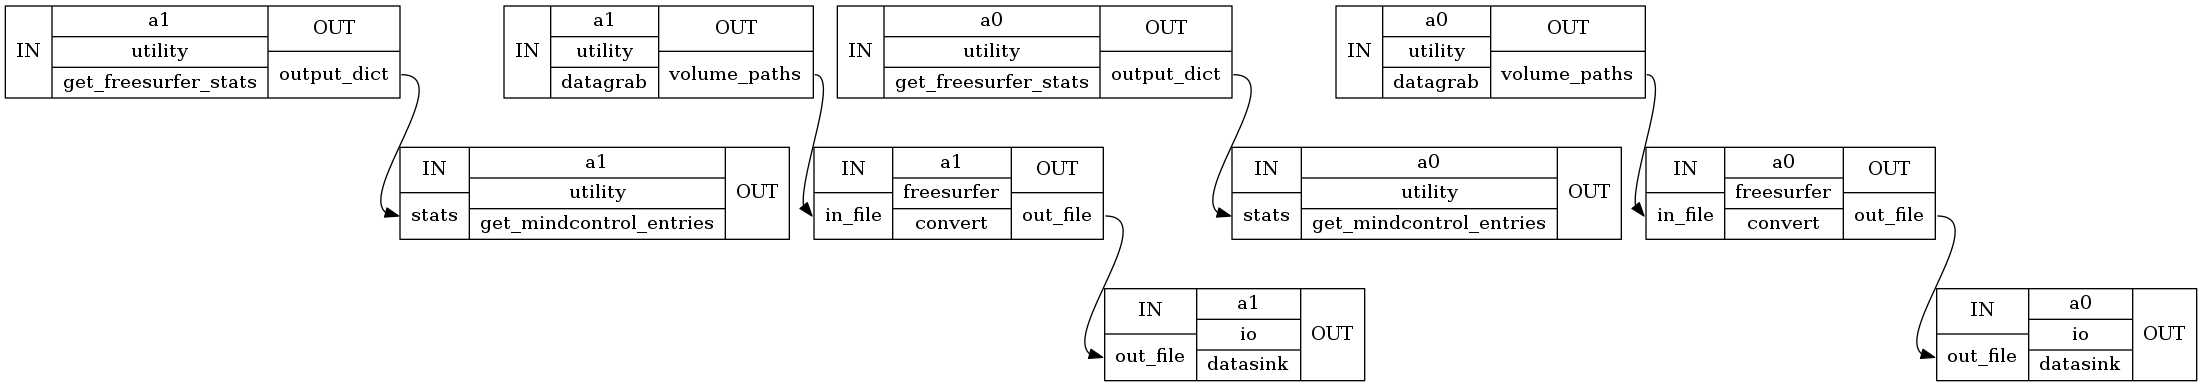

In [53]:
Image(os.path.join(workflow_working_dir, 'MindPrepFS/graph_detailed.dot.png'))

## Load JSON entries into the Mindcontrol database:

In [6]:
def get_collection(port=3001):
    from pymongo import MongoClient
    client = MongoClient("localhost", port)
    db =  client.meteor
    collection = db.subjects
    return collection, client

In [20]:
from nipype.utils.filemanip import load_json


coll, cli = get_collection()

for entry_file in glob(os.path.join(mindcontrol_outdir,"*","mindcontrol_entries.json")):
    data = load_json(entry_file)
    for d in data:
        name, entry_type = d["name"], d["entry_type"]
        query = {"name": name, "entry_type": entry_type}
        res = coll.find_one(query)
        if not res:
            coll.insert_one(d)
        else:
            coll.update_one(query, {"$set": d})
        
    

You should now see something like:
    
![](images/freesurfer_instance.png)